In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
from theano import shared
from scipy import stats
import pandas as pd
import math

# Helper functions

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def normalize(x):
    return x/np.sum(x)

def rmse(pred, actual):
    return math.sqrt(np.mean((pred-actual)**2))

def sort_category(unique, count,n):
    output = np.ones(n) - 1
    for i in range(n):
        for j in range(len(unique)):
            if(i==unique[j]):
                output[i]=count[j]
    return normalize(output) 

def perturb(x,noise=.001):
    return tt.switch(tt.eq(x,1),1-noise, tt.switch(tt.eq(x,0), noise, x))

def compute_ci_discrete(x, HDI, n, sim):
    output = [None]*sim
    for i in range(sim):
        draw = np.random.choice(x, size = n, replace = True)
        unique, counts = np.unique(draw, return_counts=True)
        output[i] = sort_category(unique, counts,4)
    lower = np.ones(len(output[0]))
    upper = np.ones(len(output[0]))
    output = np.transpose(output) # each element is now all the samples of one category
    for i in range(len(output)):
        lower[i] = np.quantile(output[i], q = (1-HDI)/2)
        upper[i] = np.quantile(output[i], q = 1-(1-HDI)/2)
    return [lower, upper]

def compute_ci_continuous(x, HDI, n, sim):
    output = np.ones(sim)
    for i in range(sim):
        draw = np.random.choice(x, size = n, replace = True)
        output[i] = np.mean(draw)
    lower = np.quantile(output, q = (1-HDI)/2)
    upper = np.quantile(output, q = 1-(1-HDI)/2)
    return [lower, upper]

def computeA(m, s):
    return (m*s)/(1-m)

# Computational models

## Data preprocessing

In [3]:
data = pd.read_csv('ecl_dat.csv', encoding="ISO-8859-1")
emotion = data.loc[data['condition'] == 'condition 1']
noemotion = data.loc[data['condition'] == 'condition 2']

### Normalization of data

In [4]:
human_cause_purple_emotion_data = (np.array(emotion["relationBlueOne"]) - 1) / 8.0
human_cause_red_emotion_data = (np.array(emotion["relationBlueTwo"]) - 1) / 8.0
human_cause_purple_noemotion_data = (np.array(noemotion["relationBlueOne"]) - 1) / 8.0
human_cause_red_noemotion_data = (np.array(noemotion["relationBlueTwo"]) - 1) / 8.0

human_belief_purple_emotion_data = (np.array(emotion["exp1"]) - 1) / 8.0
human_belief_red_emotion_data = (np.array(emotion["exp2"]) - 1) / 8.0
human_belief_purple_noemotion_data = (np.array(noemotion["exp1"]) - 1) / 8.0
human_belief_red_noemotion_data = (np.array(noemotion["exp2"]) - 1) / 8.0

human_desire_purple_emotion_data = (np.array(emotion["desire1"]) - 1) / 8.0
human_desire_red_emotion_data = (np.array(emotion["desire2"]) - 1) / 8.0
human_desire_purple_noemotion_data = (np.array(noemotion["desire1"]) - 1) / 8.0
human_desire_red_noemotion_data = (np.array(noemotion["desire2"]) - 1) / 8.0

human_knowledge_emotion_data = (np.array(emotion["knowledge1"]) - 1) / 8.0
human_knowledge_noemotion_data = (np.array(noemotion["knowledge1"]) - 1) / 8.0

### Computing means for causal, belief, desire, and knowledge inference

In [5]:
human_cause_purple_emotion = np.mean(human_cause_purple_emotion_data)
human_cause_red_emotion = np.mean(human_cause_red_emotion_data)
human_cause_purple_noemotion = np.mean(human_cause_purple_noemotion_data)
human_cause_red_noemotion = np.mean(human_cause_red_noemotion_data)

human_belief_purple_emotion = np.mean(human_belief_purple_emotion_data)
human_belief_red_emotion = np.mean(human_belief_red_emotion_data )
human_belief_purple_noemotion = np.mean(human_belief_purple_noemotion_data)
human_belief_red_noemotion = np.mean(human_belief_red_noemotion_data)

human_desire_purple_emotion = np.mean(human_desire_purple_emotion_data)
human_desire_red_emotion = np.mean(human_desire_red_emotion_data)
human_desire_purple_noemotion = np.mean(human_desire_purple_noemotion_data)
human_desire_red_noemotion = np.mean(human_desire_red_noemotion_data)

human_knowledge_emotion = np.mean(human_knowledge_emotion_data )
human_knowledge_noemotion = np.mean(human_knowledge_noemotion_data)

## Model (for the condition with no emotional display)

In [6]:
# These parameters are fixed across both conditions (emotions and no-emotions)

# The model assumes that people perceive others to have high knowledgability.
# We simulated this using a beta distribution with a = 5 and b = 2 (mean of .71).
a = 5
b = 2

In [7]:
np.random.seed(123456)

In [8]:
with pm.Model() as model1:
    world1 = pm.Beta("world1", .1, .1, shape=(1)) # inference that the box causes the purple bulb to switch on; the U-shaped beta distribution reduces the chance of "vague" inferences
    world2 = pm.Beta("world2", .1, .1, shape=(1)) # inference that the box causes the red bulb to switch on
    knowledge = pm.Deterministic("knowledge", tt.eq(1, 1)) # set knowledge = 1
    
    belief1_random = pm.Beta("belief1_random", .1, .1, shape=(1)) # belief inference that the agent thinks that the box causes the purple bulb to switch on
    belief1 = pm.Deterministic("belief1", knowledge*world1 + (1-knowledge)*belief1_random)
    belief2_random = pm.Beta("belief2_random", .1, .1, shape=(1)) # belief inference that the agent thinks that the box causes the red bulb to switch on
    belief2 = pm.Deterministic("belief2", knowledge*world2 + (1-knowledge)*belief2_random)
    
    desire = pm.Categorical("desire", [5,5,1,1], shape=(1)) # purple, red, both, others
    # Note: this prior assumes that people are more likely to desire one light bulb to turn on compared to multiple light bulbs or other alternative desires
    
    action_others_p = .05 # low prior probability of push box action
    action_p = pm.Deterministic("action_p", belief1*tt.eq(desire,0) + \
                                # if believe box -> purple and desire purple bulb to light up
                                belief2*tt.eq(desire,1) + \
                                # if believe box -> red and desire red bulb to light up
                                belief1*belief2*tt.eq(desire,2) + \
                                # if believe box -> both and desire both bulbs to light up
                                action_others_p*tt.eq(desire,3) ) # if believe box -> other event and desire some other event to occur
    action = pm.Binomial("action", 1, action_p, observed = [1])
    
    outcome1_p = pm.Deterministic("outcome1_p", action*world1) # whether purple bulb lights up
    outcome2_p = pm.Deterministic("outcome2_p", action*world2) # whether red bulb lights up
    outcome1 = pm.Binomial("outcome1", 1, outcome1_p, observed = [0])
    outcome2 = pm.Binomial("outcome2", 1, outcome2_p, observed = [1])
    
    # agent is happy if the outcome is congruent with his desires
    happy = outcome1*tt.eq(desire,0) + outcome2*tt.eq(desire,1) + outcome1*outcome2*tt.eq(desire,2)
    # agent is frustrated if the outcome does not satisfy his desires
    frustrated = tt.neq(outcome1,1)*tt.eq(desire,0)*tt.gt(belief1,.5) + tt.neq(outcome2,1)*tt.eq(desire,1)*tt.gt(belief2,.5) + tt.gt(belief1,.5)*tt.gt(belief2,.5)*tt.eq(desire,2)*tt.or_( tt.neq(outcome1,1), tt.neq(outcome2,1) )
    neutral = [1]
    emotion_array = tt.transpose(tt.stack(happy, frustrated, neutral))

    expression = pm.Categorical("expression",emotion_array,observed=[2] )
    draw = 2000 
    trace1 = pm.sample(draw, tune=1000, chains=4, return_inferencedata=False) 

# note: we compute the RMSE for reference (also useful to compare between models)
# Conceptually, however, it might be difficult to compare these predictions one-to-one as normalized human ratings is not the same as probability
world1posterior = np.mean(trace1["world1"].T[0])
print(rmse(world1posterior, human_cause_purple_noemotion))
world2posterior = np.mean(trace1["world2"].T[0])
print(rmse(world2posterior, human_cause_red_noemotion))

belief1posterior = np.mean(trace1["belief1"].T[0])
print(rmse(belief1posterior, human_belief_purple_noemotion))
belief2posterior = np.mean(trace1["belief2"].T[0])
print(rmse(belief2posterior, human_belief_red_noemotion))

unique, counts = np.unique(trace1["desire"], return_counts=True)
desire_posterior = sort_category(unique, counts,n=4)
desire1posterior = desire_posterior[0] + desire_posterior[2]/2
print(rmse(desire1posterior,human_desire_purple_noemotion))
desire2posterior = desire_posterior[1] + desire_posterior[2]/2
print(rmse(desire2posterior,human_desire_red_noemotion))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [belief2_random, belief1_random, world2, world1]
>CategoricalGibbsMetropolis: [desire]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


0.11820115666960362
0.06668014491053953
0.21641544238388932
0.16132300205339667
0.32666964285714284
0.11075892857142855


### Summary statistics

In [9]:
print("world1 posterior: " + str(np.mean(trace1["world1"])))
print("world2 posterior: " + str(np.mean(trace1["world2"])))
print("belief1: " + str(np.mean(trace1["belief1"])))
print("belief2: " + str(np.mean(trace1["belief2"])))
unique, counts = np.unique(trace1["desire"], return_counts=True)
print("desire: " + str(dict(zip(unique, counts))))
print(sort_category(unique, counts, 4))

world1 posterior: 0.13358455761611066
world2 posterior: 0.9452515734819681
belief1: 0.13358455761611066
belief2: 0.9452515734819681
desire: {0: 942, 1: 6770, 2: 175, 3: 113}
[0.11775  0.84625  0.021875 0.014125]


### Confidence intervals

In [10]:
np.random.seed(123456)
print("world1 :" + str(compute_ci_continuous(flatten(trace1["world1"]), HDI = .95, n = 56, sim = 1000))) 
print("world2 :" + str(compute_ci_continuous(flatten(trace1["world2"]), HDI = .95, n = 56, sim = 1000))) 
print("belief1 :" + str(compute_ci_continuous(flatten(trace1["belief1"]), HDI = .95, n = 56, sim = 1000))) 
print("belief2 :" + str(compute_ci_continuous(flatten(trace1["belief2"]), HDI = .95, n = 56, sim = 1000))) 
print("desire :" + str(compute_ci_discrete(flatten(trace1["desire"]), HDI = .95, n = 1000, sim = 1000)))

world1 :[0.07580605698682724, 0.19565513576830457]
world2 :[0.9078706932673027, 0.977067583179068]
belief1 :[0.07231250783036683, 0.1997513614994956]
belief2 :[0.9050043642878428, 0.9760613002504807]
desire :[array([0.098, 0.825, 0.014, 0.007]), array([0.137   , 0.869   , 0.031025, 0.022   ])]


/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/de

array([[<AxesSubplot:title={'center':'desire'}>,
        <AxesSubplot:title={'center':'desire'}>],
       [<AxesSubplot:title={'center':'world1'}>,
        <AxesSubplot:title={'center':'world1'}>],
       [<AxesSubplot:title={'center':'world2'}>,
        <AxesSubplot:title={'center':'world2'}>],
       [<AxesSubplot:title={'center':'knowledge'}>,
        <AxesSubplot:title={'center':'knowledge'}>],
       [<AxesSubplot:title={'center':'belief1_random'}>,
        <AxesSubplot:title={'center':'belief1_random'}>],
       [<AxesSubplot:title={'center':'belief1'}>,
        <AxesSubplot:title={'center':'belief1'}>],
       [<AxesSubplot:title={'center':'belief2_random'}>,
        <AxesSubplot:title={'center':'belief2_random'}>],
       [<AxesSubplot:title={'center':'belief2'}>,
        <AxesSubplot:title={'center':'belief2'}>],
       [<AxesSubplot:title={'center':'action_p'}>,
        <AxesSubplot:title={'center':'action_p'}>],
       [<AxesSubplot:title={'center':'outcome1_p'}>,
        <A

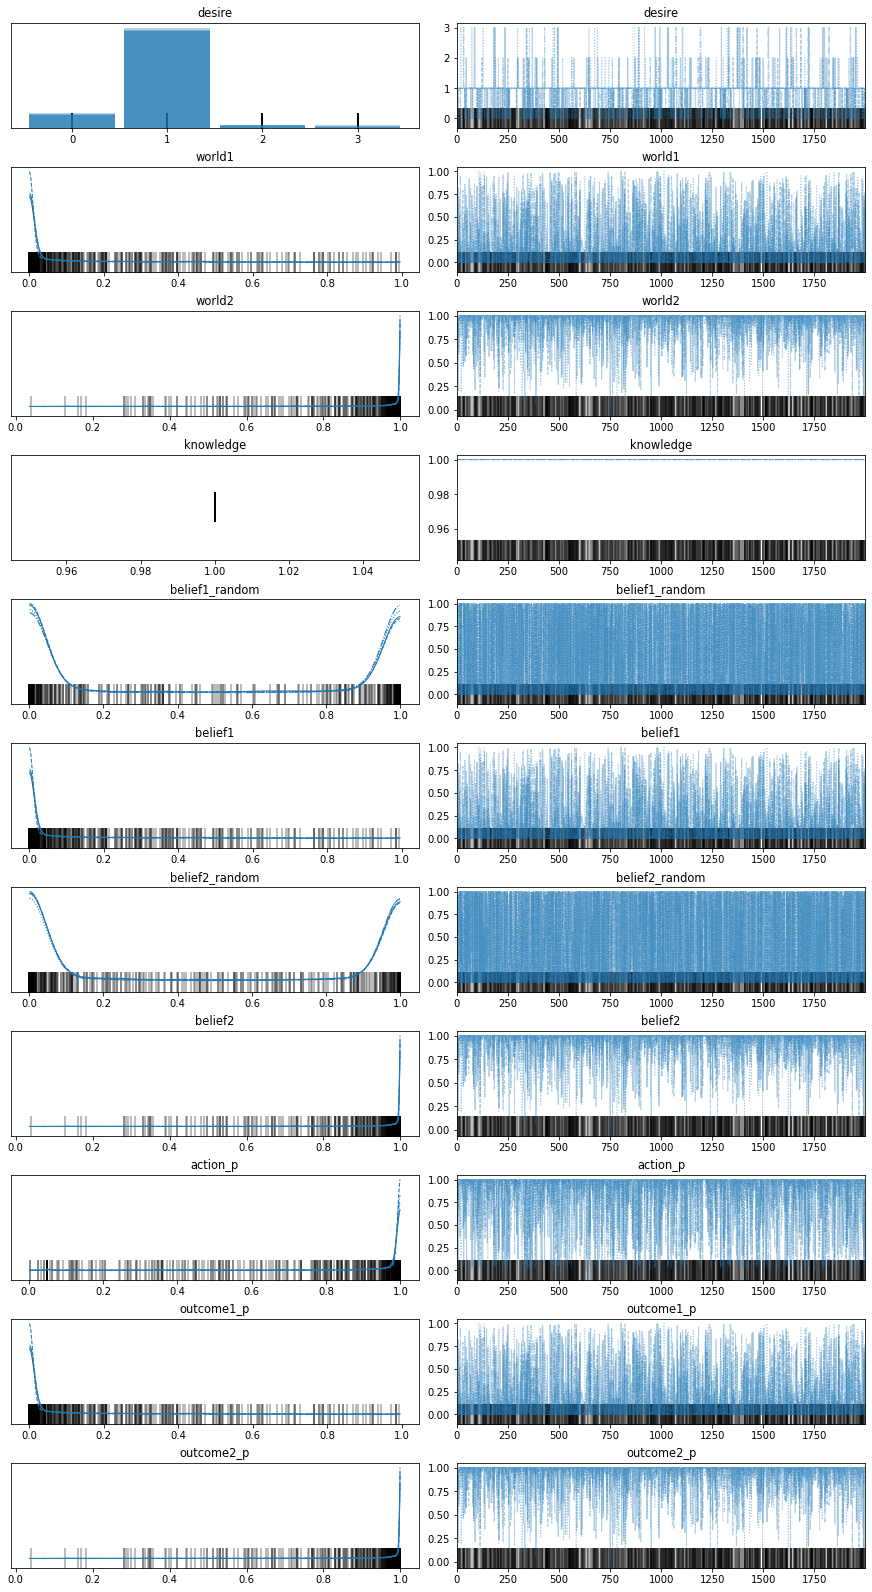

In [11]:
az.plot_trace(trace1)

## Model (for the condition with emotional displays)

In [12]:
np.random.seed(123456)

In [13]:
with pm.Model() as model2:
    world1 = pm.Beta("world1", .1, .1, shape=(1)) # inference that the box causes the purple bulb to switch on; the U-shaped beta distribution reduces the chance of "vague" inferences
    world2 = pm.Beta("world2", .1, .1, shape=(1)) # inference that the box causes the red bulb to switch on
    knowledge = pm.Deterministic("knowledge", tt.eq(1, 1)) # set knowledge = 1
    
    belief1_random = pm.Beta("belief1_random", .1, .1, shape=(1)) # belief inference that the agent thinks that the box causes the purple bulb to switch on
    belief1 = pm.Deterministic("belief1", knowledge*world1 + (1-knowledge)*belief1_random)
    belief2_random = pm.Beta("belief2_random", .1, .1, shape=(1)) # belief inference that the agent thinks that the box causes the red bulb to switch on
    belief2 = pm.Deterministic("belief2", knowledge*world2 + (1-knowledge)*belief2_random)
    
    desire = pm.Categorical("desire", [5,5,1,1], shape=(1)) # purple, red, both, others
    # Note: this prior assumes that people are more likely to desire one light bulb to turn on compared to multiple light bulbs or other alternative desires
    
    action_others_p = .05 # low prior probability of push box action
    action_p = pm.Deterministic("action_p", belief1*tt.eq(desire,0) + \
                                # if believe box -> purple and desire purple bulb to light up
                                belief2*tt.eq(desire,1) + \
                                # if believe box -> red and desire red bulb to light up
                                belief1*belief2*tt.eq(desire,2) + \
                                # if believe box -> both and desire both bulbs to light up
                                action_others_p*tt.eq(desire,3) ) # if believe box -> other event and desire some other event to occur
    action = pm.Binomial("action", 1, action_p, observed = [1])
    
    outcome1_p = pm.Deterministic("outcome1_p", action*world1) # whether purple bulb lights up
    outcome2_p = pm.Deterministic("outcome2_p", action*world2) # whether red bulb lights up
    outcome1 = pm.Binomial("outcome1", 1, outcome1_p, observed = [0])
    outcome2 = pm.Binomial("outcome2", 1, outcome2_p, observed = [1])
    
    # agent is happy if the outcome is congruent with his desires
    happy = outcome1*tt.eq(desire,0) + outcome2*tt.eq(desire,1) + outcome1*outcome2*tt.eq(desire,2) 
    # agent is frustrated if the outcome does not satisfy his desires
    frustrated = tt.neq(outcome1,1)*tt.eq(desire,0)*tt.gt(belief1,.5) + tt.neq(outcome2,1)*tt.eq(desire,1)*tt.gt(belief2,.5) + tt.gt(belief1,.5)*tt.gt(belief2,.5)*tt.eq(desire,2)*tt.or_( tt.neq(outcome1,1), tt.neq(outcome2,1) )
    neutral = [1]
    emotion_array = tt.transpose(tt.stack(perturb(happy), perturb(frustrated), perturb(neutral)))
    
    expression = pm.Categorical("expression",emotion_array,observed=[1] )
    draw = 2000 
    trace2 = pm.sample(draw, tune=1000, chains=4, return_inferencedata=False) 

# note: we compute the RMSE for reference (also useful to compare between models)
# Conceptually, however, it might be difficult to compare these predictions one-to-one as normalized human ratings is not the same as probability
world1posterior = np.mean(trace2["world1"].T[0])
print(rmse(world1posterior, human_cause_purple_emotion))
world2posterior = np.mean(trace2["world2"].T[0])
print(rmse(world2posterior, human_cause_red_emotion))

belief1posterior = np.mean(trace2["belief1"].T[0])
print(rmse(belief1posterior, human_belief_purple_emotion))
belief2posterior = np.mean(trace2["belief2"].T[0])
print(rmse(belief2posterior, human_belief_red_emotion))

unique, counts = np.unique(trace2["desire"], return_counts=True)
desire_posterior = sort_category(unique, counts,n=4)
desire1posterior = desire_posterior[0] + desire_posterior[2]/2
print(rmse(desire1posterior,human_desire_purple_emotion))
desire2posterior = desire_posterior[1] + desire_posterior[2]/2
print(rmse(desire2posterior,human_desire_red_emotion))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [belief2_random, belief1_random, world2, world1]
>CategoricalGibbsMetropolis: [desire]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
There were 297 divergences after tuning. Increase `target_accept` or reparameterize.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 181 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


0.5120445309996994
0.03062643347068672
0.0626307936756253
0.632899160743414
0.08924918831168827
0.16692288961038965


### Summary statistics

In [14]:
print("world1 posterior: " + str(np.mean(trace2["world1"])))
print("world2 posterior: " + str(np.mean(trace2["world2"])))
print("belief1: " + str(np.mean(trace2["belief1"])))
print("belief2: " + str(np.mean(trace2["belief2"])))
unique, counts = np.unique(trace2["desire"], return_counts=True)
print("desire: " + str(dict(zip(unique, counts))))
print(sort_category(unique, counts, 4))

world1 posterior: 0.7263302452854137
world2 posterior: 0.9169900698343231
belief1: 0.7263302452854137
belief2: 0.9169900698343231
desire: {0: 6556, 1: 130, 2: 1303, 3: 11}
[0.8195   0.01625  0.162875 0.001375]


### Confidence intervals

In [15]:
np.random.seed(123456)
print("world1 :" + str(compute_ci_continuous(flatten(trace2["world1"]), HDI = .95, n = 68, sim = 1000))) 
print("world2 :" + str(compute_ci_continuous(flatten(trace2["world2"]), HDI = .95, n = 68, sim = 1000))) 
print("belief1 :" + str(compute_ci_continuous(flatten(trace2["belief1"]), HDI = .95, n = 68, sim = 1000))) 
print("belief2 :" + str(compute_ci_continuous(flatten(trace2["belief2"]), HDI = .95, n = 68, sim = 1000))) 
print("desire :" + str(compute_ci_discrete(flatten(trace2["desire"]), HDI = .95, n = 1000, sim = 1000)))

world1 :[0.6848961552540167, 0.7623472537446147]
world2 :[0.8648393827621024, 0.9571657948907458]
belief1 :[0.6853412916950917, 0.7677763935580211]
belief2 :[0.8767067809116366, 0.9557545645136154]
desire :[array([0.795975, 0.009   , 0.141   , 0.      ]), array([0.843, 0.024, 0.186, 0.004])]


/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/arsatis/miniconda3/envs/cp3209/lib/python3.8/site-packages/arviz/stats/de

array([[<AxesSubplot:title={'center':'desire'}>,
        <AxesSubplot:title={'center':'desire'}>],
       [<AxesSubplot:title={'center':'world1'}>,
        <AxesSubplot:title={'center':'world1'}>],
       [<AxesSubplot:title={'center':'world2'}>,
        <AxesSubplot:title={'center':'world2'}>],
       [<AxesSubplot:title={'center':'knowledge'}>,
        <AxesSubplot:title={'center':'knowledge'}>],
       [<AxesSubplot:title={'center':'belief1_random'}>,
        <AxesSubplot:title={'center':'belief1_random'}>],
       [<AxesSubplot:title={'center':'belief1'}>,
        <AxesSubplot:title={'center':'belief1'}>],
       [<AxesSubplot:title={'center':'belief2_random'}>,
        <AxesSubplot:title={'center':'belief2_random'}>],
       [<AxesSubplot:title={'center':'belief2'}>,
        <AxesSubplot:title={'center':'belief2'}>],
       [<AxesSubplot:title={'center':'action_p'}>,
        <AxesSubplot:title={'center':'action_p'}>],
       [<AxesSubplot:title={'center':'outcome1_p'}>,
        <A

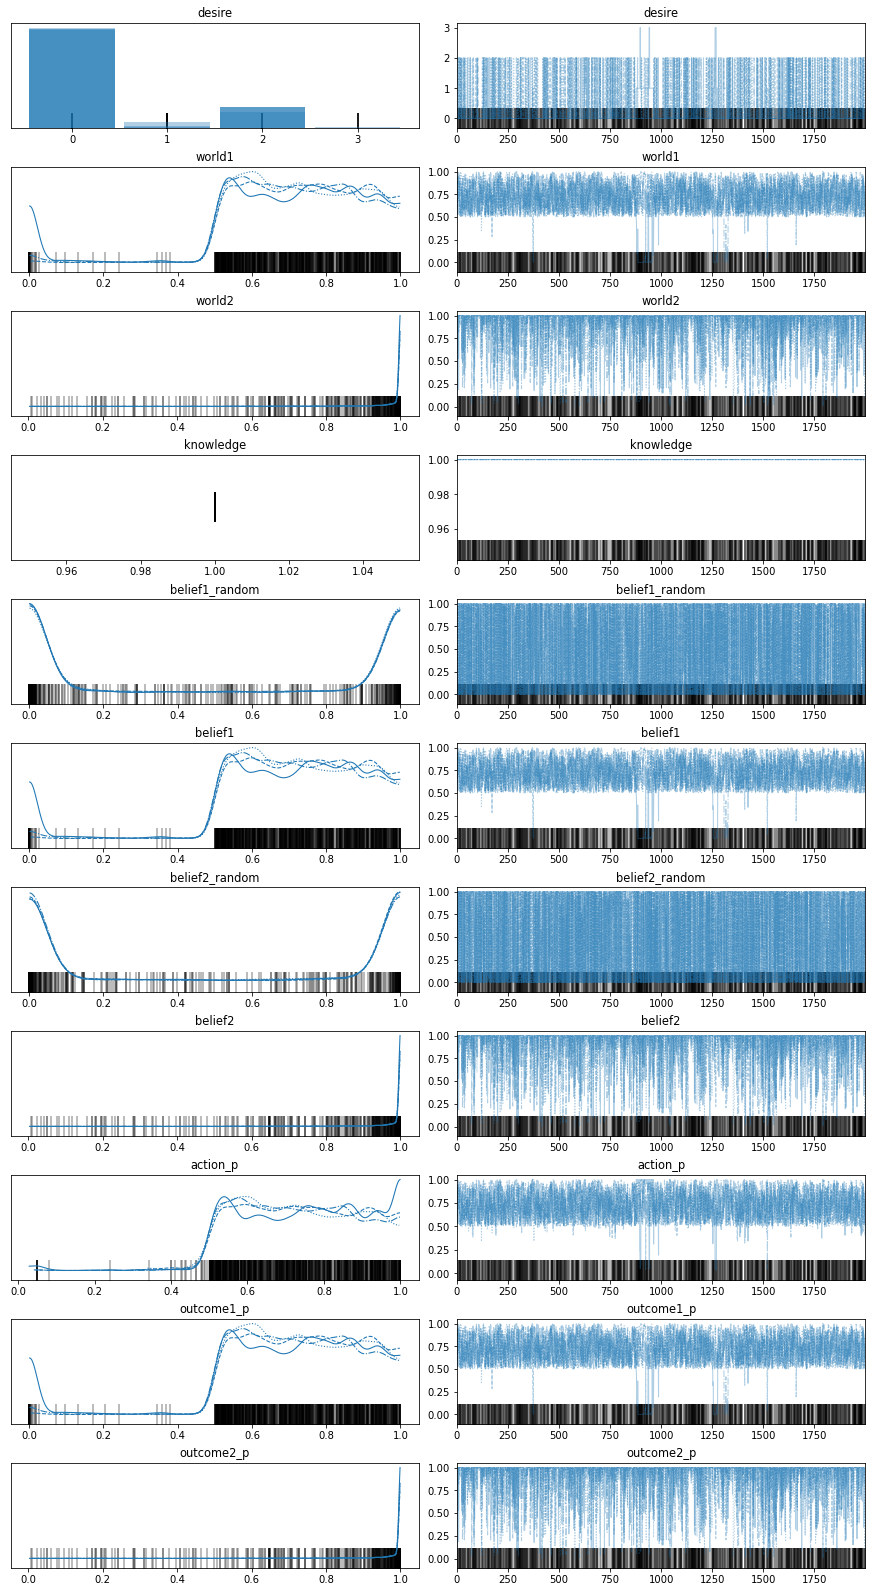

In [16]:
az.plot_trace(trace2)